In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.signal import butter
from scipy.signal import filtfilt
import re

def find_sync_file(mouse_file, animal_dat_path):
    ## find sync file: 
    for item in os.listdir(animal_dat_path):
        if mouse_file.split('_')[0] in item:
            if mouse_file.split('_')[1] == item[-1]:
                for folder in os.listdir(animal_dat_path + item):
                    if folder.split('_')[0].split('g')[-1] == mouse_file.split('_')[-1]:
                        current_animals_video_path = os.path.join(animal_dat_path + item,folder)+ r"\\video\tracking\\"
                        current_animals_behav_sync_path = os.path.join(animal_dat_path + item,folder)+ r"\\behav_sync\\"
                        for stage in os.listdir(current_animals_behav_sync_path):
                            if 'postsleep' in stage or 'post_sleep' in stage:
                                sync_path = current_animals_behav_sync_path + stage +r"\\"

    if mouse_file == '148_2_2':
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv', encoding='cp1252')
    else:
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv')
        
    return sync_df 

# new way based on Kime t al Ganguly
def butter_bandpass_filter(data, lowcut, highcut, fs, order_hp, order_lp):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # High-pass filtering
    b_hp, a_hp = butter(order_hp, low, btype='high', analog=False)
    filtered_hp = filtfilt(b_hp, a_hp, data)

    # Low-pass filtering
    b_lp, a_lp = butter(order_lp, high, btype='low', analog=False)
    filtered_band = filtfilt(b_lp, a_lp, filtered_hp)

    return filtered_band

def extract_number(filename):
    """Extracts the numerical part from the filename."""
    match = re.search(r'channel-(\d+)', filename)
    if match:
        return int(match.group(1))
    return float('inf')  # Return infinity if no number is found




paths

In [62]:
### secondary processing of the LFP, to create actual LFP averages. 
experiment_type = "learning"
LFP_dat_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\\" + experiment_type + r'\\'
# animal_dat_path = r'Z:\projects\sequence_squad\organised_data\animals\\'
animal_dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"

# check which mice havent been processed yet 
for mouse in os.listdir(LFP_dat_path):
    temp_path = os.path.join(LFP_dat_path,mouse)
    if not 'processed_data' in os.listdir(temp_path):
        print(mouse)

seq006_1_3
seq006_1_4
seq006_1_5
seq006_1_6
seq006_1_7
seq007_1_1
seq007_1_2
seq007_1_3


load the data for chosen mouse

In [55]:
mouse_file = 'seq006_1_2'

mouse_path = os.path.join(LFP_dat_path, mouse_file)
data_channels = []
channel_names = []
for channels in os.listdir(mouse_path):
    if 'striatum' in channels:
        print(channels)
        channel_path = os.path.join(mouse_path, channels)
        try:
            data_channels += [np.load(channel_path)]
        except:
            data_channels += [np.load(channel_path, allow_pickle=True)]
        channel_names +=[channels]
    elif 'timestamps' in channels:
        timestamps_df = pd.read_csv(os.path.join(mouse_path, channels))
   
# reorder them so that they ar ein channel order
sorted_inds = np.argsort([extract_number(item) for item in channel_names])
channel_names =  np.array(channel_names)[sorted_inds]
data_channels = np.array(data_channels)[sorted_inds]    


# hack to make sure that timestamps are correct length
if not len(data_channels[0]) == len(timestamps_df):
    timestamps_df = timestamps_df[0:len(data_channels[0])]
    print('timestamps and data channels are not the same length, truncating timestamps to match data channels')
            
### chop the data down to just the post sleep 

# load in the sync df to get the start time of the sleep period
sync_df = find_sync_file(mouse_file, animal_dat_path)
sleep_period_ephys_start_time = sync_df.Camera_time_Ephys_Aligned[0]
# make a mask for the sleep period
chopping_mask = timestamps_df.ephys_timestamp > sleep_period_ephys_start_time
# apply that mask to each channel and the timestamps
sleep_period_timestamps_df = timestamps_df[chopping_mask]
sleep_period_data_channels = []
for i,dat in enumerate(data_channels):
    sleep_period_data_channels += [dat[chopping_mask]]


channel-130_REGION-striatum_LFP_data.npy
channel-170_REGION-striatum_LFP_data.npy
channel-210_REGION-striatum_LFP_data.npy
channel-250_REGION-striatum_LFP_data.npy
channel-50_REGION-striatum_LFP_data.npy
channel-90_REGION-striatum_LFP_data.npy


plot the channels

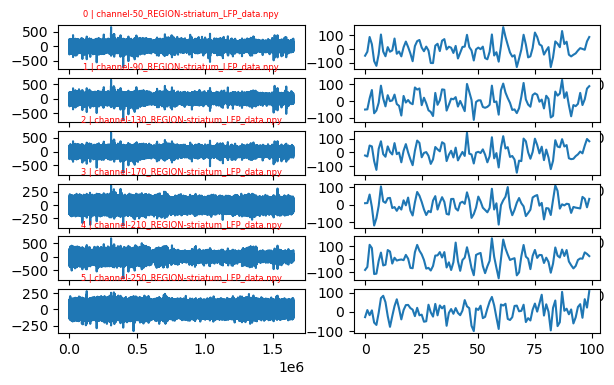

In [56]:
## chose which channels to keep 
fig, axs = plt.subplots(len(sleep_period_data_channels), 2, figsize=(7, 4))  # 2 rows, 1 column
for i,dat in enumerate(sleep_period_data_channels):
    #downsample just for visualisation
    dat = dat[::10]
    axs[i][0].plot(dat)
    axs[i][1].plot(dat[10000:10100])
    axs[i][0].set_title(f"{i} | {channel_names[i]}", fontsize=6, color = 'red')

choose non noisy channels and make an average 

Text(0.5, 1.0, 'Average LFP')

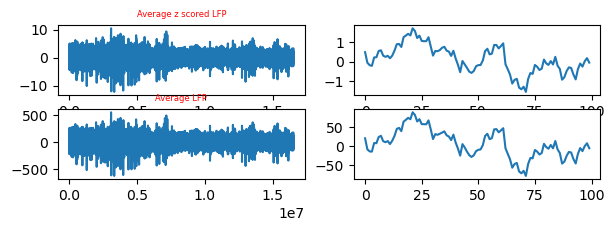

In [57]:
### choose channels 
chosen_channels_bool = [1,1,1,1,1,1,1,1]

channel_z = []
channel_ = []
for ind,dat in enumerate(sleep_period_data_channels):
    if chosen_channels_bool[ind] == 1:
        channel_z += [scipy.stats.zscore(dat)]
        channel_ += [dat]
lfp_all_z = np.vstack(channel_z) 
lfp_all = np.vstack(channel_)     
# Avg all channels
average_lfp_z = lfp_all_z.mean(axis=0) # AVG
average_lfp = lfp_all.mean(axis=0) # AVG

fig, axs = plt.subplots(2, 2, figsize=(7, 2))  # 2 rows, 1 column
axs[0][0].plot(average_lfp_z)
axs[0][1].plot(average_lfp_z[10000:10100])
axs[0][0].set_title(f"Average z scored LFP", fontsize=6, color = 'red')

axs[1][0].plot(average_lfp)
axs[1][1].plot(average_lfp[10000:10100])
axs[1][0].set_title(f"Average LFP", fontsize=6, color = 'red')



delta bandpass 

Text(0.5, 1.0, 'Average z scored delta band pass')

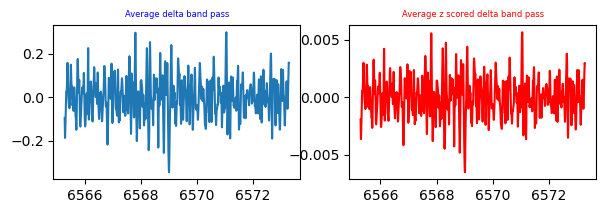

In [58]:
## band pass 

ts = sleep_period_timestamps_df.ephys_timestamp

#### filter for delta band:
fs = 2500  # Sampling frequency
lowcut = 0.5  # Cutoff frequency for high-pass filter (Hz)
highcut = 4   # Cutoff frequency for low-pass filter (Hz)
order_hp = 2  # Order of the high-pass Butterworth filter
order_lp = 2  # Order of the low-pass Butterworth filter
delta_filtered_z = butter_bandpass_filter(average_lfp_z, lowcut, highcut, fs, order_hp, order_lp) 
delta_filtered = butter_bandpass_filter(average_lfp, lowcut, highcut, fs, order_hp, order_lp) 

fig, axs = plt.subplots(1, 2, figsize=(7, 2))  # 2 rows, 1 column
axs[0].plot(ts[20000:40000],delta_filtered[20000:40000])
axs[0].set_title(f"Average delta band pass", fontsize=6, color = 'blue')
axs[1].plot(ts[20000:40000],delta_filtered_z[20000:40000], color = 'red')
axs[1].set_title(f"Average z scored delta band pass", fontsize=6, color = 'red')

spindle bandpass 

Text(0.5, 1.0, 'Average z spindle band pass')

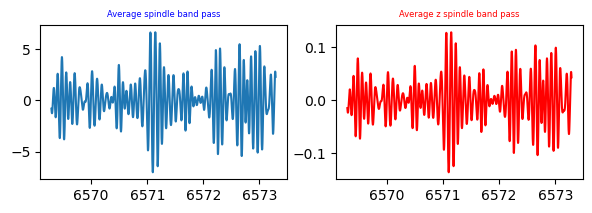

In [59]:


#The LFP average was filtered in spindle band (10-14 Hz) through two independent filtering; 
#the high pass Butterworth filter (6th order, zero phase shifted, with a cutoff at 10 Hz) was applied and 
#then followed by the low pass Butterworth filter (8th order, zero phase shifted, with a cutoff at 14Hz).
lowcut = 9  # Cutoff frequency for high-pass filter (Hz)
highcut = 14   # Cutoff frequency for low-pass filter (Hz)
order_hp = 6  # Order of the high-pass Butterworth filter
order_lp = 8  # Order of the low-pass Butterworth filter

spindle_filtered = butter_bandpass_filter(average_lfp, lowcut, highcut, fs, order_hp, order_lp) # crop for plotting
spindle_filtered_z = butter_bandpass_filter(average_lfp_z, lowcut, highcut, fs, order_hp, order_lp) # crop for plotting

fig, axs = plt.subplots(1, 2, figsize=(7, 2))  # 2 rows, 1 column
axs[0].plot(ts[30000:40000],spindle_filtered[30000:40000])
axs[0].set_title(f"Average spindle band pass", fontsize=6, color = 'blue')
axs[1].plot(ts[30000:40000],spindle_filtered_z[30000:40000], color = 'red')
axs[1].set_title(f"Average z spindle band pass", fontsize=6, color = 'red')


fast v slow spindle bandpass

Text(0.5, 1.0, 'Average z slow spindle band pass')

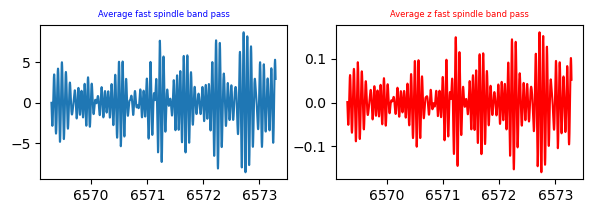

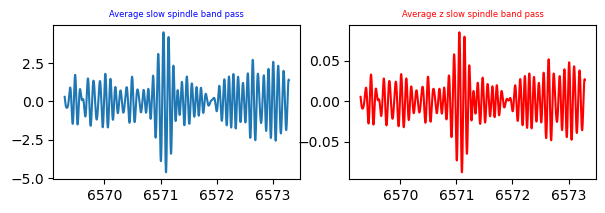

In [60]:

#### fast spindles
lowcut = 12  # Cutoff frequency for high-pass filter (Hz)
highcut = 16   # Cutoff frequency for low-pass filter (Hz)
order_hp = 6  # Order of the high-pass Butterworth filter
order_lp = 8  # Order of the low-pass Butterworth filter
fast_spindle_filtered = butter_bandpass_filter(average_lfp, lowcut, highcut, fs, order_hp, order_lp)
fast_spindle_filtered_z = butter_bandpass_filter(average_lfp_z, lowcut, highcut, fs, order_hp, order_lp)

fig, axs = plt.subplots(1, 2, figsize=(7, 2))  # 2 rows, 1 column
axs[0].plot(ts[30000:40000],fast_spindle_filtered[30000:40000])
axs[0].set_title(f"Average fast spindle band pass", fontsize=6, color = 'blue')
axs[1].plot(ts[30000:40000],fast_spindle_filtered_z[30000:40000], color = 'red')
axs[1].set_title(f"Average z fast spindle band pass", fontsize=6, color = 'red')


#### slow spindles
lowcut = 9  # Cutoff frequency for high-pass filter (Hz)
highcut = 12   # Cutoff frequency for low-pass filter (Hz)
order_hp = 6  # Order of the high-pass Butterworth filter
order_lp = 8  # Order of the low-pass Butterworth filter
slow_spindle_filtered = butter_bandpass_filter(average_lfp, lowcut, highcut, fs, order_hp, order_lp)
slow_spindle_filtered_z = butter_bandpass_filter(average_lfp_z, lowcut, highcut, fs, order_hp, order_lp)

fig, axs = plt.subplots(1, 2, figsize=(7, 2))  # 2 rows, 1 column
axs[0].plot(ts[30000:40000],slow_spindle_filtered[30000:40000])
axs[0].set_title(f"Average slow spindle band pass", fontsize=6, color = 'blue')
axs[1].plot(ts[30000:40000],slow_spindle_filtered_z[30000:40000], color = 'red')
axs[1].set_title(f"Average z slow spindle band pass", fontsize=6, color = 'red')


save out av lfp and bandpasses

In [61]:
outpath = mouse_path + '/processed_data/' 
if not os.path.exists(outpath):
    os.makedirs(outpath)

np.save(outpath + 'average_lfp.npy',average_lfp)
np.save(outpath + 'average_lfp_zscored.npy',average_lfp_z)

np.save(outpath + 'delta_bandpassed.npy',delta_filtered)
np.save(outpath + 'zscored_delta_bandpassed.npy',delta_filtered_z)

np.save(outpath + 'spindle_bandpassed.npy',spindle_filtered)
np.save(outpath + 'zscored_spindle_bandpassed.npy',spindle_filtered_z)

np.save(outpath + 'fast_spindle_bandpassed.npy',fast_spindle_filtered)
np.save(outpath + 'zscored_fast_spindle_bandpassed.npy',fast_spindle_filtered_z)

np.save(outpath + 'slow_spindle_bandpassed.npy',slow_spindle_filtered)
np.save(outpath + 'zscored_slow_spindle_bandpassed.npy',slow_spindle_filtered_z)

print(f'all saved for {mouse_file}!')




all saved for seq006_1_2!
